In [ ]:
seqlen = 8

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import linecache
import csv
import pandas as pd
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:
dataset = torch.load('moving_minst_data.pt')

In [ ]:
dataset_seq=[]

for i in range(0,len(dataset)-(len(dataset)%seqlen),seqlen):
    dataset_seq.append(dataset[i:i+seqlen, :])
dataset_seq=torch.stack(dataset_seq, dim=0)

In [ ]:
dataset_seq= dataset_seq.permute(0,2,1,3,4)

In [ ]:
print(dataset_seq.shape)

torch.Size([1250, 1, 8, 64, 64])


In [ ]:
m=len(dataset_seq)
train_data, val_data, test_data = dataset_seq[:int(m*0.6)], dataset_seq[int(m*0.6):int(m*0.8)],dataset_seq[int(m*0.8):]

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self,in_channels,out_channels,kernels_size, padding, activation, frame_size):
        super(ConvLSTMCell,self).__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "relu":
            self.activation = torch.relu
        self.conv=nn.Conv2d(in_channels=in_channels+out_channels,out_channels=4*out_channels,kernel_size=kernels_size,padding=padding)
        self.W_ci=nn.Parameter(torch.Tensor(out_channels,*frame_size))
        self.W_co=nn.Parameter(torch.Tensor(out_channels,*frame_size))
        self.W_cf=nn.Parameter(torch.Tensor(out_channels,*frame_size))

    def forward(self, X , H_prev, C_prev):
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)
        output_gate = torch.sigmoid(o_conv + self.W_co * C )
        H = output_gate * self.activation(C)
        return H, C


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels,
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, height, width, device=device)

        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding,
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding,
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        )

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding,
                    activation=activation, frame_size=frame_size)
                )

            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                )

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers

        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])

        return nn.Sigmoid()(output)

In [ ]:
train_loader=DataLoader(train_data,shuffle=False,batch_size=16)
val_loader = DataLoader(val_data,shuffle=False,batch_size=16)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.BCELoss(reduction='sum')

In [ ]:
lastLoss=0
num_epochs = 100
for epoch in range(1, num_epochs+1):
    train_loss = 0
    model.train()
    for batch_num, seq_data in enumerate(train_loader):
        input = seq_data[:,:,:seqlen-1,:,:].to(device)
        target = seq_data[:,:,seqlen-1:,:,:].to(device)

        output = model(input)
        loss = criterion(output.flatten(), target.flatten())
        loss = ((output.flatten()-target.flatten())**2).sum()
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)


    val_loss = 0
    model.eval()
    with torch.no_grad():
        for seq_data in val_loader:
            input = seq_data[:,:,:seqlen-1,:,:].to(device)
            target = seq_data[:,:,seqlen-1:,:,:].to(device)
            output = model(input)

            loss = criterion(output.flatten(), target.flatten())
            # loss = ((output.flatten()-target.flatten())**2).sum()
            val_loss += loss.item()
    val_loss /= len(val_loader.dataset)


    if abs(lastLoss-train_loss) < 0.2:
        break
    print(train_loss)
    lastLoss = train_loss

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(epoch, train_loss, val_loss))



165.22965397135417
Epoch:1 Training Loss:165.23 Validation Loss:1614.90

106.16433968098958
Epoch:2 Training Loss:106.16 Validation Loss:672.66

79.58501595052083
Epoch:3 Training Loss:79.59 Validation Loss:384.76

64.68153377278645
Epoch:4 Training Loss:64.68 Validation Loss:342.49

56.940195556640624
Epoch:5 Training Loss:56.94 Validation Loss:320.76

51.904361979166666
Epoch:6 Training Loss:51.90 Validation Loss:305.43

48.21400203450521
Epoch:7 Training Loss:48.21 Validation Loss:289.93

45.19504890950521
Epoch:8 Training Loss:45.20 Validation Loss:279.00

42.595122721354166
Epoch:9 Training Loss:42.60 Validation Loss:269.64

39.95453442382812
Epoch:10 Training Loss:39.95 Validation Loss:265.09

37.64572538248698
Epoch:11 Training Loss:37.65 Validation Loss:263.48

35.78842423502604
Epoch:12 Training Loss:35.79 Validation Loss:258.84

33.93986490885417
Epoch:13 Training Loss:33.94 Validation Loss:250.97

32.158635131835936
Epoch:14 Training Loss:32.16 Validation Loss:245.25

30.569

In [ ]:
test_loader = DataLoader(test_data,shuffle=False,batch_size=16)

In [ ]:
print(test_data.shape)

torch.Size([250, 1, 8, 64, 64])


In [ ]:
print(len(test_loader))
for batch_num, seq_data in enumerate(test_loader):
    input = seq_data[:,:,:seqlen-1,:,:].to(device)

    target = seq_data[:,:,seqlen-1:,:,:].to(device)

    if(batch_num==0):
        continue
    print(input.shape)
    output = model(input)
    output=output.cpu()
    target=target.cpu()
    break
    fig, axs = plt.subplots(8, 2,figsize=(10,5))
    for i in range(len(output)):
        axs[i,0].imshow(output[i][0].detach().numpy(),cmap='jet',extent = [sLong,eLong,eLati,sLati])
        axs[i,1].imshow(target[i][0].detach().numpy(),cmap='jet',extent = [sLong,eLong,eLati,sLati])
    for ax in axs.flat:
        ax.set(xlabel='Longitude', ylabel='Latitude')

16
torch.Size([16, 1, 7, 64, 64])


tensor(12.3799, grad_fn=<SumBackward0>)
tensor(5.2179, grad_fn=<SumBackward0>)
tensor(12.4941, grad_fn=<SumBackward0>)
tensor(37.0667, grad_fn=<SumBackward0>)
tensor(26.2951, grad_fn=<SumBackward0>)
tensor(8.3796, grad_fn=<SumBackward0>)
tensor(18.4511, grad_fn=<SumBackward0>)
tensor(11.6920, grad_fn=<SumBackward0>)
tensor(26.3883, grad_fn=<SumBackward0>)
tensor(11.9943, grad_fn=<SumBackward0>)
tensor(26.0111, grad_fn=<SumBackward0>)
tensor(13.4159, grad_fn=<SumBackward0>)
tensor(8.2648, grad_fn=<SumBackward0>)
tensor(16.5394, grad_fn=<SumBackward0>)
tensor(12.3570, grad_fn=<SumBackward0>)
tensor(26.0149, grad_fn=<SumBackward0>)


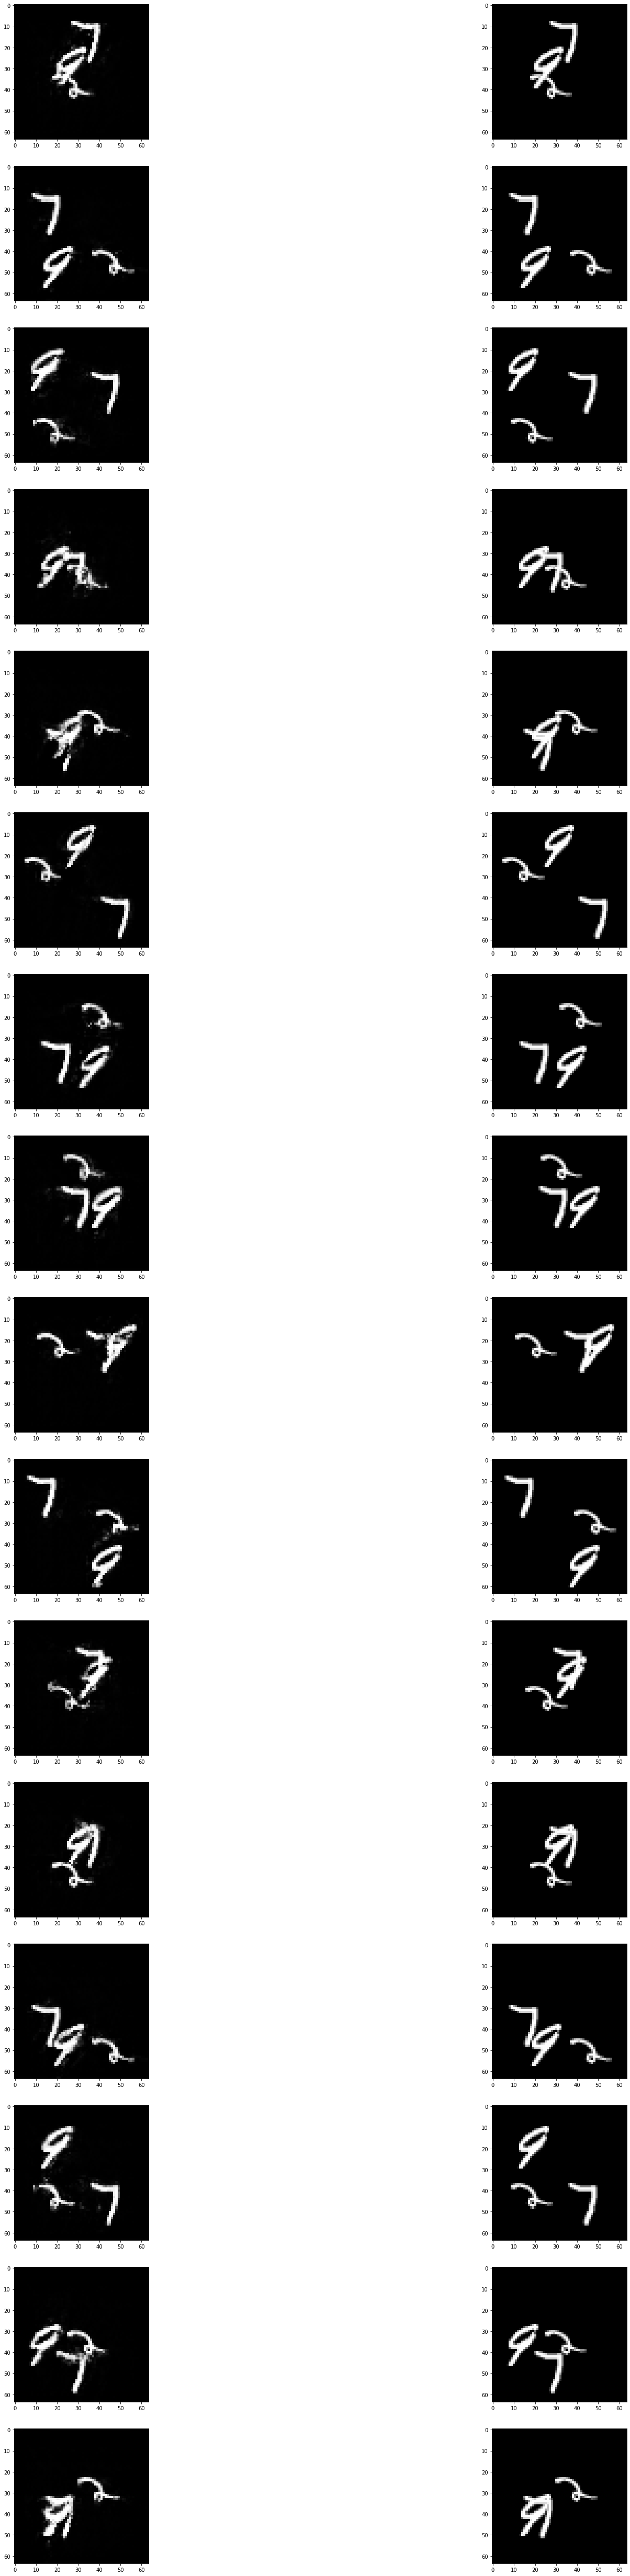

In [ ]:
fig, axs = plt.subplots(16, 2,figsize=(30,90))

for i in range(len(output)):

    axs[i,0].imshow(output[i][0].detach().numpy(),cmap='gray')

    axs[i,1].imshow(target[i][0][0].detach().numpy(),cmap='gray')
    print(((output[i][0]-target[i][0][0])**2).sum())

    # plt.figure(figsize=(20,10))
    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")
    # plt.imshow(output[i][0].detach().numpy(),cmap='jet',extent = [sLong,eLong,eLati,sLati])
    # cbar = plt.colorbar()
    # cbar.set_label("mg/l")
    # plt.show()

tensor(232.5820, device='cuda:0', grad_fn=<SumBackward0>)


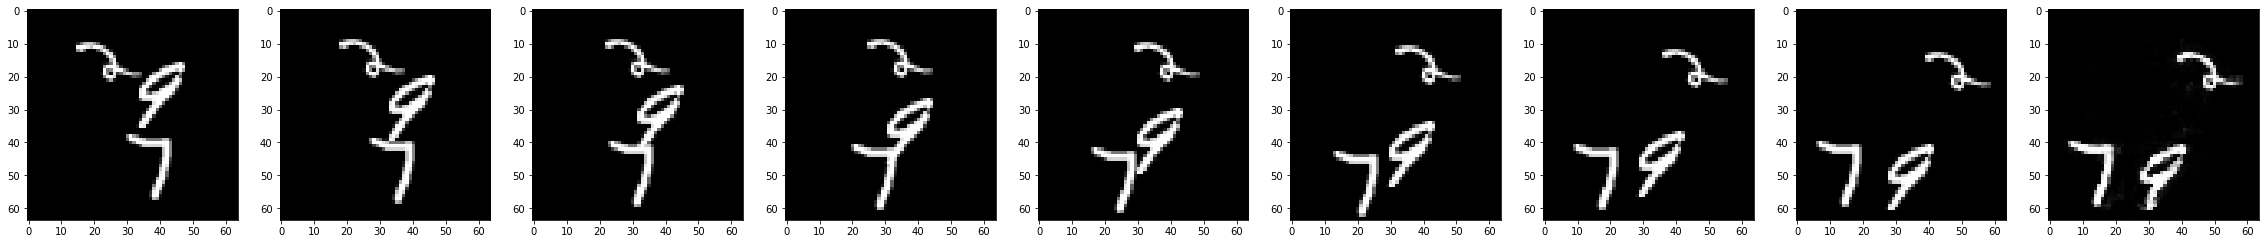

In [ ]:
one = np.random.randint(len(test_data))
one = 3
x = test_data[one].unsqueeze(0).to(device)

input = x[:,:,:seqlen-1,:,:].to(device)

target = x[:,:,seqlen-1:,:,:].to(device)

y_origin = x

predicts = model(input)

predict = predicts[:,-1:,:,:]

# y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

# y_preds=torch.sum((torch.normal(mu, sigma)*pi),dim=2)

# y_preds  = torch.normal(mu, sigma).gather(2,pi.max(2)[1].unsqueeze(2)).squeeze(2)

# pi_t=pi.transpose(2, 3)
# pi_t_r=pi_t.reshape(pi_t.size(0)*pi_t.size(1)*pi_t.size(2),pi_t.size(3))
# k = torch.multinomial(pi_t_r, 1).view(-1)
# k_r = k.reshape(pi_t.size(0),pi_t.size(1),pi_t.size(2)).unsqueeze(2)
# y_preds = torch.normal(mu, sigma).gather(2,k_r).squeeze(2)

# compare_result=torch.cat([x,y]+y_preds)
fig, axs = plt.subplots(1, 9,figsize=(40,90))


print(predict.sum())
axs[0].imshow(y_origin[0][0][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)

axs[1].imshow(y_origin[0][0][1].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[2].imshow(y_origin[0][0][2].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[3].imshow(y_origin[0][0][3].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[4].imshow(y_origin[0][0][4].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[5].imshow(y_origin[0][0][5].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[6].imshow(y_origin[0][0][6].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[7].imshow(y_origin[0][0][7].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[8].imshow(predicts[0][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)

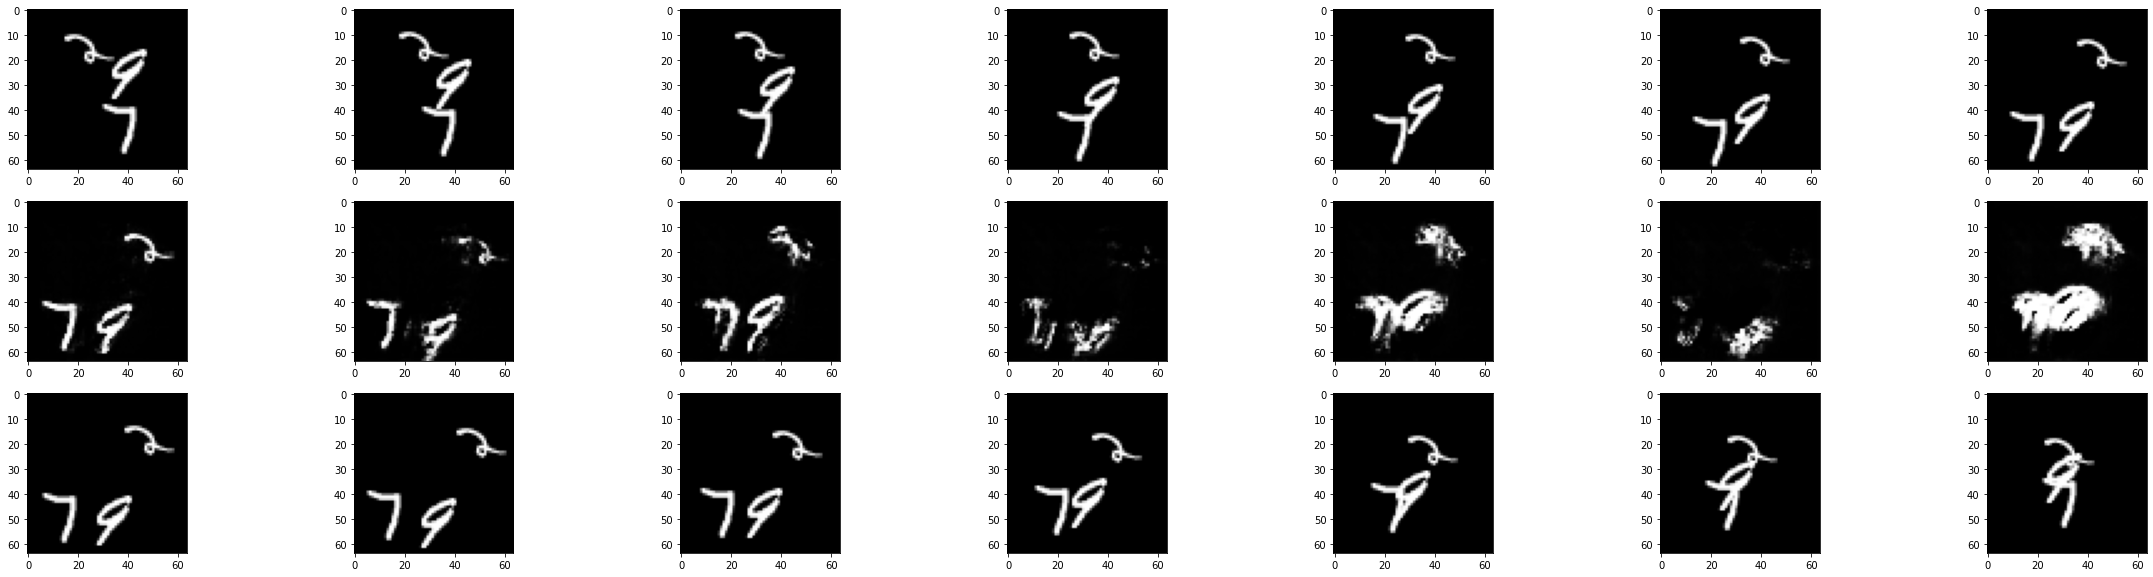

In [ ]:
one = np.random.randint(len(test_data))
one = 3
x = test_data[one].unsqueeze(0).to(device)


predict_length = 7
predict_result = []
origin_input = x
for i in range(predict_length):
    input = x[:,:,:seqlen-1,:,:].to(device)

    predicts = model(input)

    predict = predicts[:,-1:,:,:]

    predict_result.append(predict)
    x = torch.cat([x[:,:,1:],predict.unsqueeze(0)],dim=2)

fig, axs = plt.subplots(3, 7,figsize=(40,10))
for i in range(x.size(2)-1):
    axs[0,i].imshow(origin_input[0][0][i].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)

for j in range(len(predict_result)):

    axs[1,j].imshow(predict_result[j][0][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)


truth =torch.cat([origin_input[:,:,-1:], test_data[one+1][:predict_length].unsqueeze(0).to(device)],dim=2)

for k in range(x.size(2)-1):
    axs[2,k].imshow(truth[0][0][k].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)